This file will show how left speed in cozmo can be classified between anger and sorow

# Lessons from this:

### From Fig 1.
#### The average speed in anger is higher than sorrow. Sorrow tends to be idle far more often than anger 
### From Fig 2.
#### The area under the curve on speed, is very low on sorrow, meaning that it is very probable that the whole speed in sorrow is low or not at all (idle)

# 1 Input Packages

In [1]:
import sys
!{sys.executable} -m pip install tslearn tslearn tqdm -U

Requirement already up-to-date: tslearn in /anaconda3/lib/python3.7/site-packages (0.3.0)
Requirement already up-to-date: tqdm in /anaconda3/lib/python3.7/site-packages (4.43.0)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

Using TensorFlow backend.


# 2 Variables and structures

In [3]:
valence_values=['interest','alarm', 'confusion', 'understanding', 'frustration', 'relief',
       'sorrow', 'joy', 'anger', 'gratitude', 'fear', 'hope', 'boredom',
       'surprise', 'disgust', 'desire']
cozmo_feature='right_wheel_speed'
seq_len=60

# 3 Load Data

In [4]:
d = pickle.load( open( "data/all_affect_dataframe.p", "rb" ) )

# 4 Generate subset of data, one per affect

In [5]:
def getSubsetViaAffect(affect='', dataframe='', mutuallyExclusive=True):
    vectorMaxLenght=60
    retVal=[]
    
    #for a in range(0, len(dataframe), 60):
    for a in tqdm(range(0, len(dataframe), 60)):
        tmp=(dataframe[a:a+60])
        if ((mutuallyExclusive == True) and ((np.sum(list(tmp.Y)[0])) > 1)):
            continue
        # remove Y column
        tmp2=tmp.drop(['Y'],axis=1)
        tmp3=tmp2.loc[(tmp2!=0).any(1)]
        feat=(list(tmp.Y))[0]
        features=[]
        for i in range(len(feat)):
            if 1 in feat:
                features.append(valence_values[feat.index(1)])
                feat[feat.index(1)]=0
            else:
                break
            
        for f in features:
            if f == affect:
                retVal.append(tmp3)
        
    return retVal

In [6]:
anger=getSubsetViaAffect(affect='anger', dataframe=d, mutuallyExclusive=False)

In [7]:
d = pickle.load( open( "data/all_affect_dataframe.p", "rb" ) )
sorrow=getSubsetViaAffect(affect='sorrow', dataframe=d, mutuallyExclusive=False)

# 5 Distributions between the two affects
### Objective: See patterns of general behavior in terms of speed


In [8]:
cozmo_feature

'right_wheel_speed'

In [9]:
anger_list=[np.sum(list(abs(a[cozmo_feature])))/60 for a in anger]
sorrow_list=[np.sum(list(abs(a[cozmo_feature])))/60 for a in sorrow]

## Fig 1.- PDF of average speed on each animation (full 60 samples per animation)

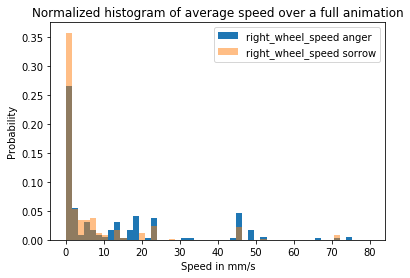

In [10]:
_, bins, _ = plt.hist(anger_list, bins=50, range=[0,80], density=True, 
                      label=['{} anger'.format(cozmo_feature)])
_ = plt.hist(sorrow_list, bins=bins, alpha=0.5, density=True, 
             label=['{} sorrow'.format(cozmo_feature)])
plt.legend(loc='best')
plt.xlabel('Speed in mm/s')
plt.ylabel('Probability')
plt.title('Normalized histogram of average speed over a full animation')
plt.show()

# 6 Integral per animation and make histogram of the areas under the curve.
## This is using the discrete aproximation by trapezoidal rule.
### Objective: Contrary to the average speed, I want to learn the total area of speed in an animation. This will give me a clue of how much speed in a full animation each affect tends to have.

In [11]:
anger_integral=[]
for a in anger:
    left=list(a[cozmo_feature])
    # absolute values onlly
    res = list(map(abs, left)) 
    anger_integral.append(np.trapz(res))
sorrow_integral=[]
for a in sorrow:
    left=list(a[cozmo_feature])
    # absolute values onlly
    res = list(map(abs, left)) 
    sorrow_integral.append(np.trapz(res))

# Fig 2.- Integral of speed on each animation

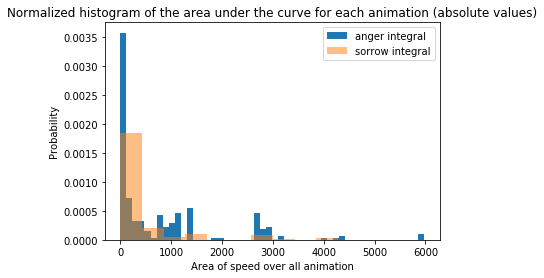

In [12]:
_, bins, _ = plt.hist(anger_integral, bins=50,  density=True, label=['anger integral'])
_ = plt.hist(sorrow_integral,  alpha=0.5, density=True, label=['sorrow integral'])
plt.legend(loc='upper right')
plt.xlabel('Area of speed over all animation')
plt.ylabel('Probability')
plt.title('Normalized histogram of the area under the curve for each animation (absolute values)')
plt.show()

# 7 Clustering time series
### Objective: Detect patterns on each affect in the time series

In [13]:
# Data is the list of datagrams
def cluster_patterns(data, clusters, title):
    all_data=[list(a.left_wheel_speed) for a in data]
    X_train = np.asarray(all_data)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
    # DBA-k-means
    dba_km = TimeSeriesKMeans(n_clusters=clusters,
                        n_init=6,
                        max_iter=5000,
                        dtw_inertia=True,
                        metric="dtw",
                        verbose=False,
                        max_iter_barycenter=10,
                        random_state=0,
                        n_jobs=-1)
    y_pred = dba_km.fit_predict(X_train)
    plt.figure(figsize=(15,4))
    for yi in range(clusters):
        plt.subplot(1, clusters, yi + 1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        #plt.xlim(0, sz)
        #plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
        if yi == 1:
            plt.title(title)



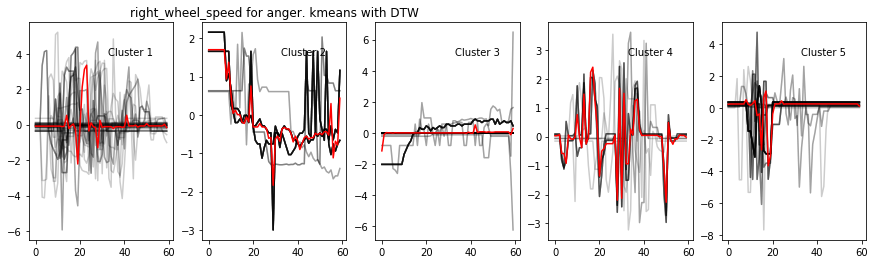

In [14]:
cluster_patterns(anger, 5, "{} for anger. kmeans with DTW".format(cozmo_feature))

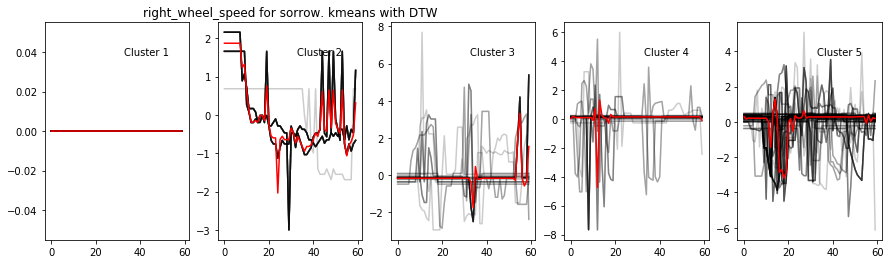

In [15]:
cluster_patterns(sorrow, 5, "{} for sorrow. kmeans with DTW".format(cozmo_feature))

# Classification time series

https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/

In [16]:
def splitdf(df1='',df2=''):
    y1=[1]*len(df1)
    y2=[0]*len(df2)
    X=df1+df2
    Y=y1+y2
    X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                        test_size=0.33, 
                                                        random_state=0)
    print(len(X_train),len(y_train))
    print(len(X_test),len(y_test))
    return X_train, X_test, y_train, y_test

    
X_train_t, X_test, y_train_t, y_test=splitdf(df1=anger, df2=sorrow)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_t, y_train_t, 
                                                        test_size=0.33, 
                                                        random_state=0)

377 377
186 186


In [17]:
len(X_train), len(X_validation), len(X_test)

(252, 125, 186)

In [18]:
len(y_train), len(y_validation), len(y_test)

(252, 125, 186)

In [19]:
def convert_to_ts(data, feature):
    concat_list=[[list(d[cozmo_feature])] for d in data]
    return np.array(concat_list)
X_train=convert_to_ts(X_train,cozmo_feature)
X_validation=convert_to_ts(X_validation,cozmo_feature)
X_test=convert_to_ts(X_test,cozmo_feature)

In [20]:
X_train.shape, X_validation.shape, X_test.shape

((252, 1, 60), (125, 1, 60), (186, 1, 60))

In [21]:
train = X_train
validation = X_validation
test = X_test
train_target=np.array(y_train)
validation_target=np.array(y_validation)
test_target=np.array(y_test)

In [22]:
#row,cols=train.shape
#train = train.reshape(1,row, cols)
#row,cols=train_target.shape
#train_target = train_target.reshape(1,row, cols)

#row,cols=validation.shape
#validation = validation.reshape(1,row, cols)
#row,cols=validation_target.shape
#validation_target = validation_target.reshape(1,row, cols)

#row,cols=test.shape
#test = test.reshape(1,row, cols)
#row,cols=test_target.shape
#test_target = test_target.reshape(1,row, cols)



In [23]:
model = Sequential()
model.add(LSTM(256, input_shape=(1,seq_len)))
model.add(Dense(1, activation='sigmoid'))

W0310 16:11:04.527257 4474963392 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0310 16:11:04.542069 4474963392 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0310 16:11:04.544092 4474963392 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               324608    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 324,865
Trainable params: 324,865
Non-trainable params: 0
_________________________________________________________________


In [25]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))
#model.fit(train, train_target, epochs=200, batch_size=128)


W0310 16:11:04.804411 4474963392 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0310 16:11:04.809583 4474963392 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0310 16:11:04.813764 4474963392 deprecation.py:323] From //anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0310 16:11:05.550570 4474963392 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.com

Train on 252 samples, validate on 125 samples
Epoch 1/200
252/252 [==============================] - 1s 3ms/step - loss: 0.6953 - acc: 0.5952 - val_loss: 0.6620 - val_acc: 0.6240

Epoch 00001: val_acc improved from -inf to 0.62400, saving model to best_model.pkl
Epoch 2/200
252/252 [==============================] - 0s 92us/step - loss: 0.6038 - acc: 0.7063 - val_loss: 0.6247 - val_acc: 0.6400

Epoch 00002: val_acc improved from 0.62400 to 0.64000, saving model to best_model.pkl
Epoch 3/200
252/252 [==============================] - 0s 90us/step - loss: 0.5588 - acc: 0.7421 - val_loss: 0.6096 - val_acc: 0.6320

Epoch 00003: val_acc did not improve from 0.64000
Epoch 4/200
252/252 [==============================] - 0s 84us/step - loss: 0.5375 - acc: 0.7341 - val_loss: 0.6027 - val_acc: 0.6560

Epoch 00004: val_acc improved from 0.64000 to 0.65600, saving model to best_model.pkl
Epoch 5/200
252/252 [==============================] - 0s 79us/step - loss: 0.5196 - acc: 0.7460 - val_loss: 0

In [26]:
#loading the model and checking accuracy on the test data
model = load_model('best_model.pkl')

from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test)
accuracy_score(test_target, test_preds)

0.6720430107526881

In [27]:
test_target[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])